In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import sys 
sys.path.append('..')
from animake import AniMaker
from codeprint import RawCode

## D* Lite search algorithm (Dynamic A*)

In [3]:
from dstarlite import *

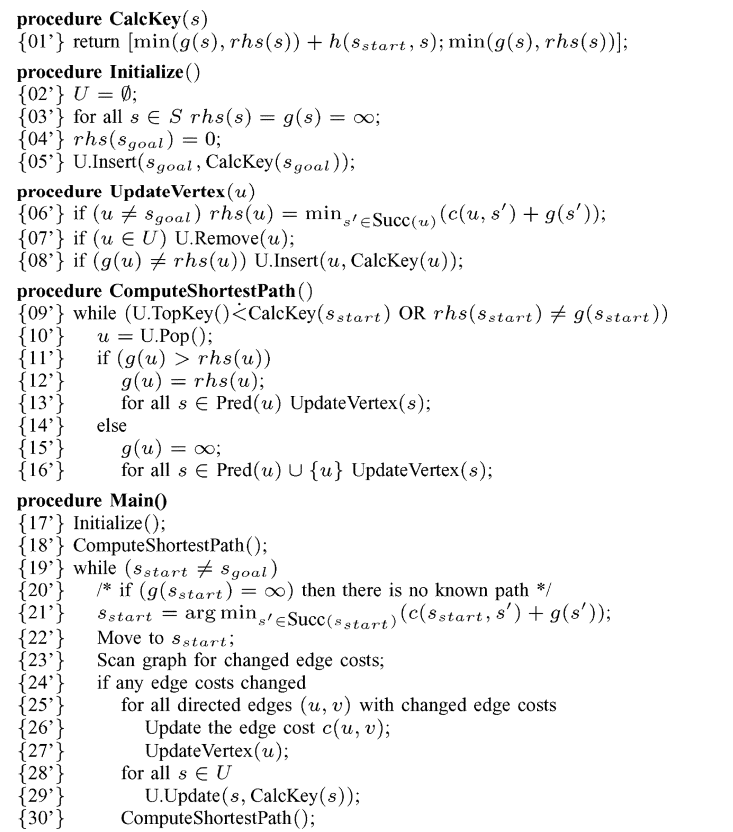

In [4]:
from IPython.display import Image
Image(filename="dstarlite_pseudocode.png", width=500)

In [5]:
code = RawCode('dstarlite.py')
code.show('Node')

class Node():
    def __init__(self, pos):
        self.pos = pos
        self.g = np.inf
        self.rhs = np.inf
        self.h = np.inf
    
    def __eq__(self,other):
        return self.pos == other.pos
    
    def __sub__(self, other):
        #1-norm, manhattan distance
        return np.linalg.norm(np.array(self.pos) - np.array(other.pos), 1) 
    
    def __lt__(self, other):
        key1 = (min(self.g,self.rhs)+self.h, min(self.g,self.rhs))
        key2 = (min(other.g,other.rhs)+other.h, min(other.g,other.rhs))
        return key1 < key2
    def __repr__(self):
        return '{0},{1},{2},{3}'.format(self.pos,self.g,self.rhs,self.h)


In [6]:
code.show('Graph')

class Graph():
    def __init__(self, maps):
        self.maps = maps
        self.make_node_map()

    def make_node_map(self):
        map_w, map_h = self.maps.shape[1], self.maps.shape[0]
        self.node_map = np.empty([map_w, map_h], dtype=Node)
        for i in range(map_w):
            for j in range(map_h):
                self.node_map[i,j] = Node((i,j))

    def get_distance(self, node1, node2):
        pos1, pos2 = node1.pos, node2.pos
        if self.is_obstacle(pos1) or self.is_obstacle(pos2):
            return np.inf
        manhattan = np.linalg.norm(np.array(pos1)-np.array(pos2),1)
        if manhattan==1:
            return 1
        elif manhattan==2:
            return 1.4
        else:
            return np.inf
    
    def get_neighbor_nodes(self, node, direction):
        x,y = node.pos
        if direction=='hv':
            nbrs = [(x+1,y), (x,y-1), (x-1,y), (x,y+1)]
        elif direction=='diag':
            nbrs = [(x+1,y+1), (x+1,y-1), (x-1,y-1), (x-1,y+1)

In [7]:
code.show('DstarLiteAlg')

class DstarLiteAlg(Graph):
    def __init__(self, start, end, maps):
        self.maps = maps
        Graph.__init__(self, maps)
        self.start = self.node_map[start]
        self.end = self.node_map[end]
        self.end.rhs = 0.0
        self.open_list = [self.end]

    def update_vertex(self,node):
        if node != self.end :
            nbr_g_list = [nbr.g+self.get_distance(node,nbr) for nbr in self.get_neighbor_nodes(node,'all')]
            node.rhs = np.min(nbr_g_list)
        if node in self.open_list:
            self.open_list.remove(node)
        if node.g != node.rhs:
            self.open_list.append(node)
    
    def compute_shortest_path(self):
        max_iter = 1000
        for i in range(max_iter):
            is_find_goal = (self.start.g==self.start.rhs) and (self.start.g != np.inf)
            is_open_empty = len(self.open_list) == 0
            if is_find_goal or is_open_empty:
                break

            curr = self.open_list.pop(0)
            if cu

In [8]:
code.show('DstarLite')

class DstarLite(DstarLiteAlg):
    def __init__(self, start, end, maps):
        DstarLiteAlg.__init__(self, start, end, maps)
        #calculate heuristics
        for node in np.ravel(self.node_map):
            node.h = node - self.start
    

    
    def print_map(self, istext=False, show_path=False, show_search_nodes=False):
        ax = plt.gca()
        
        map_to_plot = self.maps.copy()
        robot = plt.Circle(self.start.pos, 0.4, ec='k', fc=None)
        
        
        
        ax.add_artist(robot)
        if istext==True:
            yy,xx = self.node_map.shape
            for y in np.arange(1, yy-1)[::-1]:
                for x in np.arange(1, xx-1):
                    node = self.node_map[x,y]
                    g = str(round(node.g, 2))
                    rhs = str(round(node.rhs, 2))
                    ax.text(x,y,'g:'+g+'\n rhs:' +rhs, horizontalalignment='center', verticalalignment='center')
                    
        if show_path==True:
            pa

In [9]:
def make_map(start, end, size, seed=42):
    map_size = [x+2 for x in size]
    empty, obstacle, unseen_obstacle = 0, 6, 4
    np.random.seed(seed)
    map_ = np.random.choice([empty, obstacle, unseen_obstacle], size=map_size, p=[4/7, 1/7, 2/7])
    map_[:,0], map_[0,:] = 9, 9
    map_[:,-1], map_[-1,:] = 9, 9
    map_[start] = 1
    map_[end] = 2
    return map_

### Initialize 
- set start, goal point
- make map
- purple:Known obstacle, red: Unknown obstacles

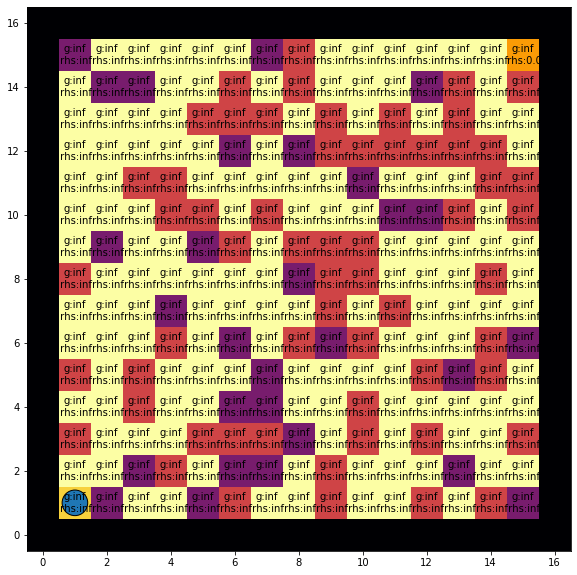

In [10]:
start = (1,1)
end = (15,15)
maps = make_map(start, end, (15,15), seed=15)
dlite = DstarLite(start=start, end=end, maps=maps)
fig, ax = plt.subplots(figsize=[10,10])
dlite.print_map(istext=True)

### Compute First Path

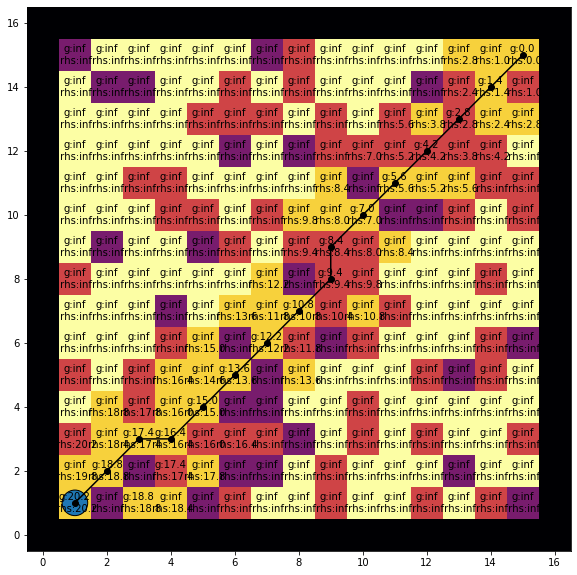

In [11]:
dlite.compute_shortest_path()
fig, ax = plt.subplots(figsize=[10,10])
dlite.print_map(istext=True, show_search_nodes=True, show_path=True)

In [12]:
max_iter=100
for it in range(max_iter):
    next_node = dlite.get_node_to_go(dlite.start)

    if dlite.is_collision(next_node):
        state = 'Collision: remake path'
        change_node = dlite.get_node_to_go(dlite.start)
        dlite.maps[change_node.pos] = 6
        dlite.update_vertex(change_node)
        for nbr in dlite.get_neighbor_nodes(change_node,'all'):
            dlite.update_vertex(nbr)
        dlite.compute_shortest_path()
    elif dlite.start==dlite.end:
        state = 'Goal!'
        break
    else:
        state = 'Go One Step'
        dlite.start = next_node

    if dlite.is_no_path():
        state = 'No known path'
        
print(state)


Goal!


### Visualization

In [13]:
anim = AniMaker()

In [14]:
dlite = DstarLite(start=start, end=end, maps=maps)
fig, ax = plt.subplots(figsize=[5,5])
dlite.print_map(show_search_nodes=True)
ax.set_xlabel('Start!')
anim.set_snapshot(num=20)
plt.close()

image added:  20


In [15]:
dlite.compute_shortest_path()
fig, ax = plt.subplots(figsize=[5,5])
dlite.print_map(show_search_nodes=True, show_path=True)
ax.set_xlabel('Initial path')
anim.set_snapshot(num=20)
plt.close()

image added:  40


In [16]:
fig, ax = plt.subplots(figsize=[5,5])

max_iter=100
for it in range(max_iter):
    next_node = dlite.get_node_to_go(dlite.start)

    if dlite.is_collision(next_node):
        state = 'Collision: remake path'
        dlite.print_map(show_path=True, show_search_nodes=True)
        ax.set_xlabel(state)
        anim.set_snapshot(num=10)
        plt.cla()
        
        change_node = dlite.get_node_to_go(dlite.start)
        dlite.maps[change_node.pos] = 6
        dlite.update_vertex(change_node)
        for nbr in dlite.get_neighbor_nodes(change_node,'all'):
            dlite.update_vertex(nbr)
        dlite.compute_shortest_path()
        frame = 10
        
    elif dlite.start==dlite.end:
        state = 'Goal!'
        frame = 20
        dlite.print_map(show_path=True, show_search_nodes=True)
        ax.set_xlabel(state)
        anim.set_snapshot(num=frame)
        plt.cla()
        break
    else:
        state = 'Go One Step'
        dlite.start = next_node
        frame = 5

    if dlite.is_no_path():
        state = 'No known path'
    
    dlite.print_map(show_path=True, show_search_nodes=True)
    ax.set_xlabel(state)
    anim.set_snapshot(num=frame)
    plt.cla()
        
print(state)
plt.close()


image added:  335
Goal!


In [17]:
anim.make_gif('out_dstarlite.gif')

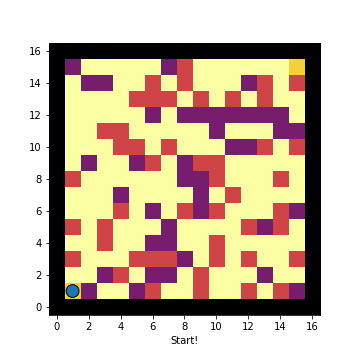

In [18]:
from IPython.display import Image
Image(filename="out_dstarlite.gif")